#### GA Analysis

This code varies the masked section of pLac to see how it relates to the upper and lower bounds of the promoter's expression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import time
import itertools

from GA_param_function_module import *

In [ ]:
cnn_model_path = '../../Models/CNN_6_1_2.keras'
target_expressions = [0, 1]
precision = 0.001
run_per_combination = 20

# Assuming 20bp up element, 6bp -35, 18bp spacer, 6bp -10, 24bp discriminator, and 17bp ITR
pLac_full = 'AATACTAGAGGTCTTCCGACTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGGCGGGAAGACAACTAGGGG'
pLac = {
    'UP' : 'AATACTAGAGGTCTTCCGAC',
    'h35' : 'TTTACA',
    'spacs' : 'CTTTATGCTTCCGGCTCG',
    'h10' : 'TATGTT',
    'disc' : 'GTGTGGGC',
    'ITR' : 'GGGAAGACAACTAGGGG',
}

In [85]:
ga = GeneticAlgorithm(
    cnn_model_path=cnn_model_path,
    masked_sequence=pLac_full,
    generations=1,
    pop_size=1,
    base_mutation_rate=0,
    target_expression=0,
    precision=precision,
    print_progress=False,
    seed=0,
)
_pLac, pLac_expr = ga.run()
print(pLac_expr)

0.33783603


c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Testing expression ranges for each element independantly

In [ ]:
# Each element individually
mask_combinations = [[each] for each in pLac.keys()]

In [ ]:
individual_results = []

# Initialize tqdm progress bar
total_iterations = len(mask_combinations) * len(target_expressions) * run_per_combination
progress_bar = tqdm(total=total_iterations, desc="Processing Combinations")

start_time = time.time()

for combination in mask_combinations:
    # Generate the masked sequence
    masked_sequence = pLac_full
    for element in combination:
        masked_sequence = masked_sequence.replace(pLac[element], 'N' * len(pLac[element]))

    # Run the GA with the masked sequence for high and low expression
    for target_expression in target_expressions:
        for run_id in range(run_per_combination):
            ga = GeneticAlgorithm(
                cnn_model_path=cnn_model_path,
                masked_sequence=masked_sequence,
                target_expression=target_expression,
                precision=precision,
                print_progress=False,
                seed=run_id,
            )
            best_sequence, best_prediction = ga.run()

            # Save the individual_results in a dictionary
            individual_results.append({
                'combination': '_'.join(combination),
                'target_expression': target_expression,
                'run_id': run_id,
                'best_sequence': best_sequence,
                'best_prediction': best_prediction,
            })

            # Update progress bar
            progress_bar.update(1)
            elapsed_time = time.time() - start_time
            progress_bar.set_postfix({
                "Elapsed": f"{elapsed_time:.2f}s",
                "ETA": f"{(elapsed_time / progress_bar.n) * (total_iterations - progress_bar.n):.2f}s"
            })

# Close progress bar
progress_bar.close()

# Save the individual_results in a dataframe
individual_results_df = pd.DataFrame(individual_results)


Processing Combinations:   0%|          | 0/240 [00:00<?, ?it/s]c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Instructions for updating:
Use tf.identity with explicit device placement instead.


Processing Combinations: 100%|██████████| 240/240 [08:08<00:00,  2.03s/it, Elapsed=488.39s, ETA=0.00s]  


In [57]:
individual_results_df.to_csv('individual_results.csv', index=False)

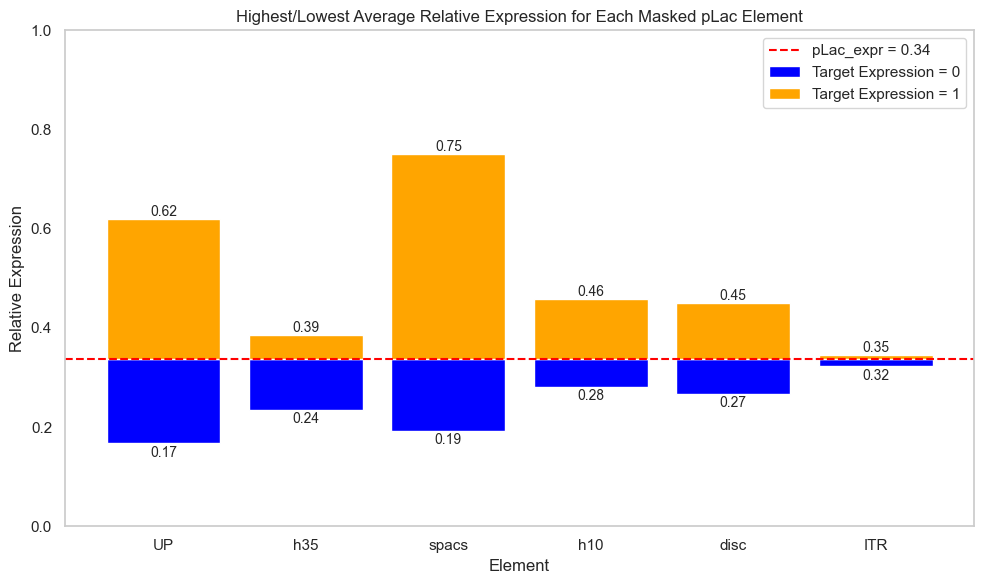

In [89]:
order = ['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']
average_individual_results = individual_results_df.groupby(['combination', 'target_expression'])['best_prediction'].mean().reset_index()
average_individual_results['combination'] = pd.Categorical(average_individual_results['combination'], categories=order, ordered=True)
average_individual_results = average_individual_results.sort_values('combination')

plt.figure(figsize=(10, 6))

data_target_0 = average_individual_results[average_individual_results['target_expression'] == 0]
data_target_1 = average_individual_results[average_individual_results['target_expression'] == 1]

bars_0 = plt.bar(data_target_0['combination'], data_target_0['best_prediction'] - pLac_expr,
                 bottom=pLac_expr, label='Target Expression = 0', color='blue')
bars_1 = plt.bar(data_target_1['combination'], data_target_1['best_prediction'] - pLac_expr,
                 bottom=pLac_expr, label='Target Expression = 1', color='orange')

for bar, label in zip(bars_0, data_target_0['best_prediction']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y() - 0.005,
             f'{label:.2f}', ha='center', va='top', fontsize=10)

for bar, label in zip(bars_1, data_target_1['best_prediction']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y(),
             f'{label:.2f}', ha='center', va='bottom', fontsize=10)

plt.axhline(y=pLac_expr, color='red', linestyle='--', label=f'pLac_expr = {pLac_expr:.2f}')

plt.xlabel('Element')
plt.ylabel('Relative Expression')
plt.ylim(0, 1)
plt.title('Highest/Lowest Average Relative Expression for Each Masked pLac Element')
plt.legend()
plt.tight_layout()
plt.grid(False)

plt.show()


### Testing expression ranges for continuous element combinations

In [48]:
# # calculate all combinations of pLac elements
# mask_combinations = []
# for r in range(1, len(pLac.keys()) + 1):
#     mask_combinations.extend(itertools.combinations(pLac.keys(), r))

# Generate all continuous combinations
elements = ['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']
mask_combinations = []
for size in range(1, len(elements) + 1):
    for i in range(len(elements) - size + 1):
        mask_combinations.append(elements[i:i+size])

In [49]:
continuous_results = []

# Initialize tqdm progress bar
total_iterations = len(mask_combinations) * len(target_expressions) * run_per_combination
progress_bar = tqdm(total=total_iterations, desc="Processing Combinations")

start_time = time.time()

for combination in mask_combinations:
    # Generate the masked sequence
    masked_sequence = pLac_full
    for element in combination:
        masked_sequence = masked_sequence.replace(pLac[element], 'N' * len(pLac[element]))

    # Run the GA with the masked sequence for high and low expression
    for target_expression in target_expressions:
        for run_id in range(run_per_combination):
            ga = GeneticAlgorithm(
                cnn_model_path=cnn_model_path,
                masked_sequence=masked_sequence,
                target_expression=target_expression,
                precision=precision,
                print_progress=False,
                seed=run_id,
            )
            best_sequence, best_prediction = ga.run()

            # Save the continuous_results in a dictionary
            continuous_results.append({
                'UP' : 'UP' in combination,
                'h35' : 'h35' in combination,
                'spacs' : 'spacs' in combination,
                'h10' : 'h10' in combination,
                'disc' : 'disc' in combination,
                'ITR' : 'ITR' in combination,
                'combination_length': len(combination),
                'target_expression': target_expression,
                'run_id': run_id,
                'best_sequence': best_sequence,
                'best_prediction': best_prediction,
            })

            # Update progress bar
            progress_bar.update(1)
            elapsed_time = time.time() - start_time
            progress_bar.set_postfix({
                "Elapsed": f"{elapsed_time:.2f}s",
                "ETA": f"{(elapsed_time / progress_bar.n) * (total_iterations - progress_bar.n):.2f}s"
            })

# Close progress bar
progress_bar.close()

# Save the continuous_results in a dataframe
continuous_results_df = pd.DataFrame(continuous_results)


Processing Combinations:   0%|          | 0/840 [00:00<?, ?it/s]c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
Processing Combinations: 100%|██████████| 840/840 [29:54<00:00,  2.14s/it, Elapsed=1794.40s, ETA=0.00s]  


In [58]:
continuous_results_df.to_csv('continuous_results.csv', index=False)

In [95]:
continuous_results_df.head()

,UP,h35,spacs,h10,disc,ITR,combination_length,target_expression,run_id,best_sequence,best_prediction,combination
0,True,False,False,False,False,False,1,0,0,GTCGGACGCGTGCAAAATGATTTACACTTTATGCTTCCGGCTCGTA...,0.184432,UP
1,True,False,False,False,False,False,1,0,1,GCACAGCGTGCATCTGACATTTTACACTTTATGCTTCCGGCTCGTA...,0.197058,UP
2,True,False,False,False,False,False,1,0,2,GTACCACCCTCGTCGAATCATTTACACTTTATGCTTCCGGCTCGTA...,0.168223,UP
3,True,False,False,False,False,False,1,0,3,GTGCACACGCCTCCGAAGCGTTTACACTTTATGCTTCCGGCTCGTA...,0.161218,UP
4,True,False,False,False,False,False,1,0,4,GTACACCTGCCGCGAGACGGTTTACACTTTATGCTTCCGGCTCGTA...,0.164283,UP


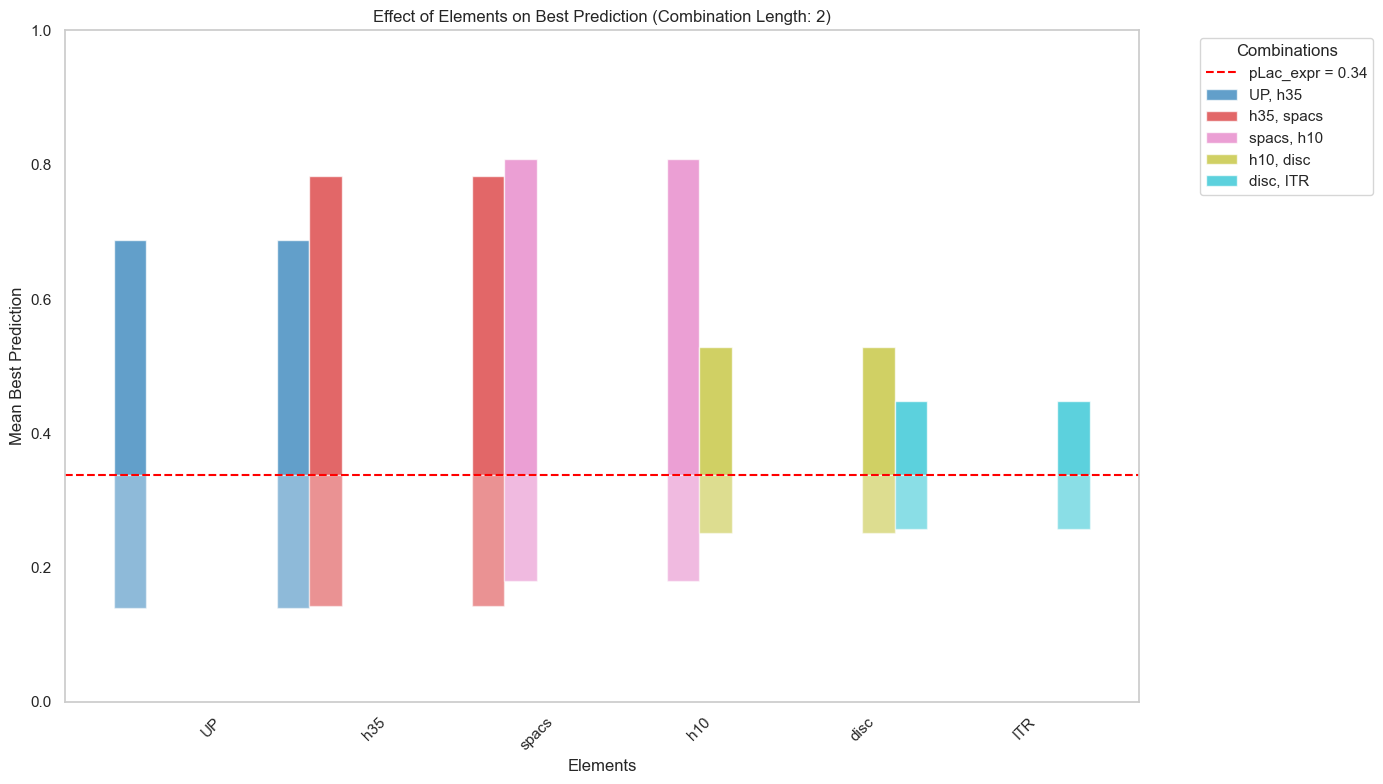

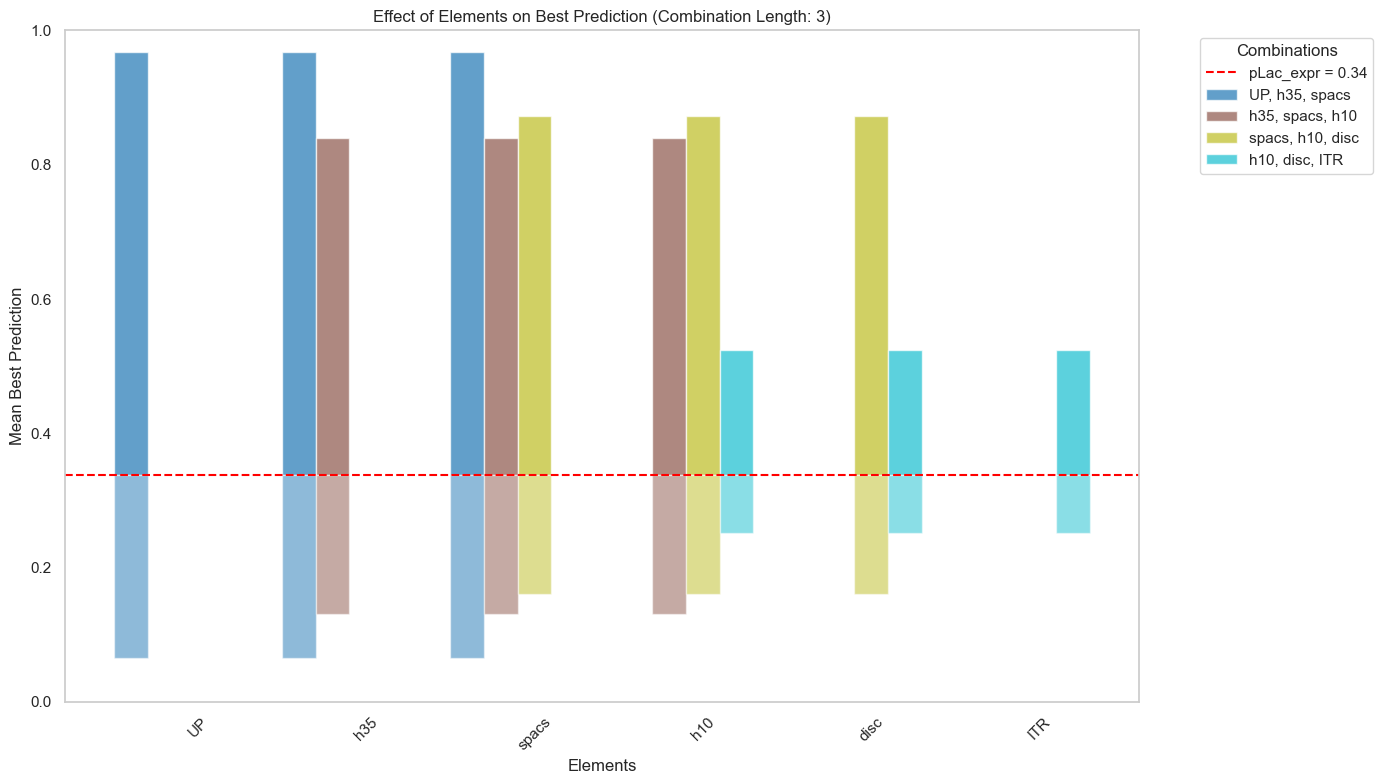

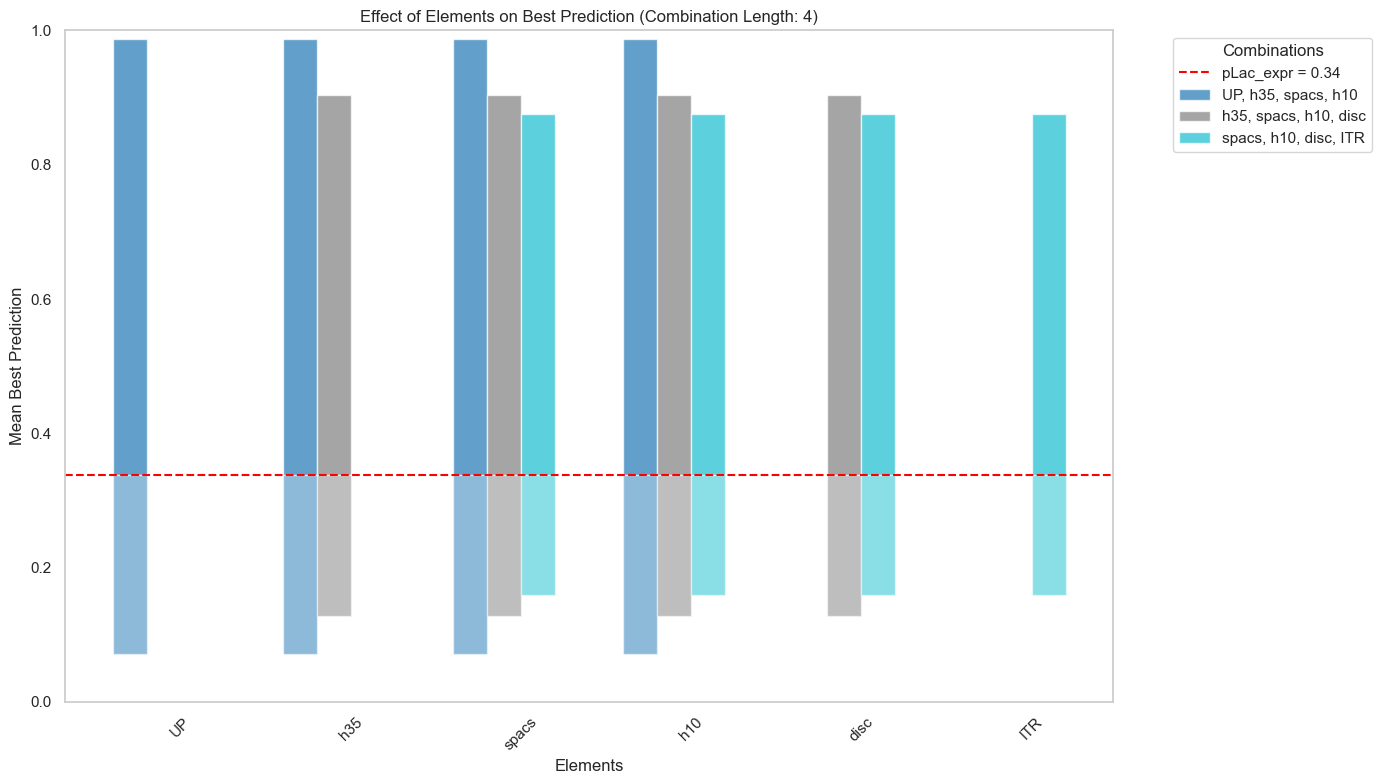

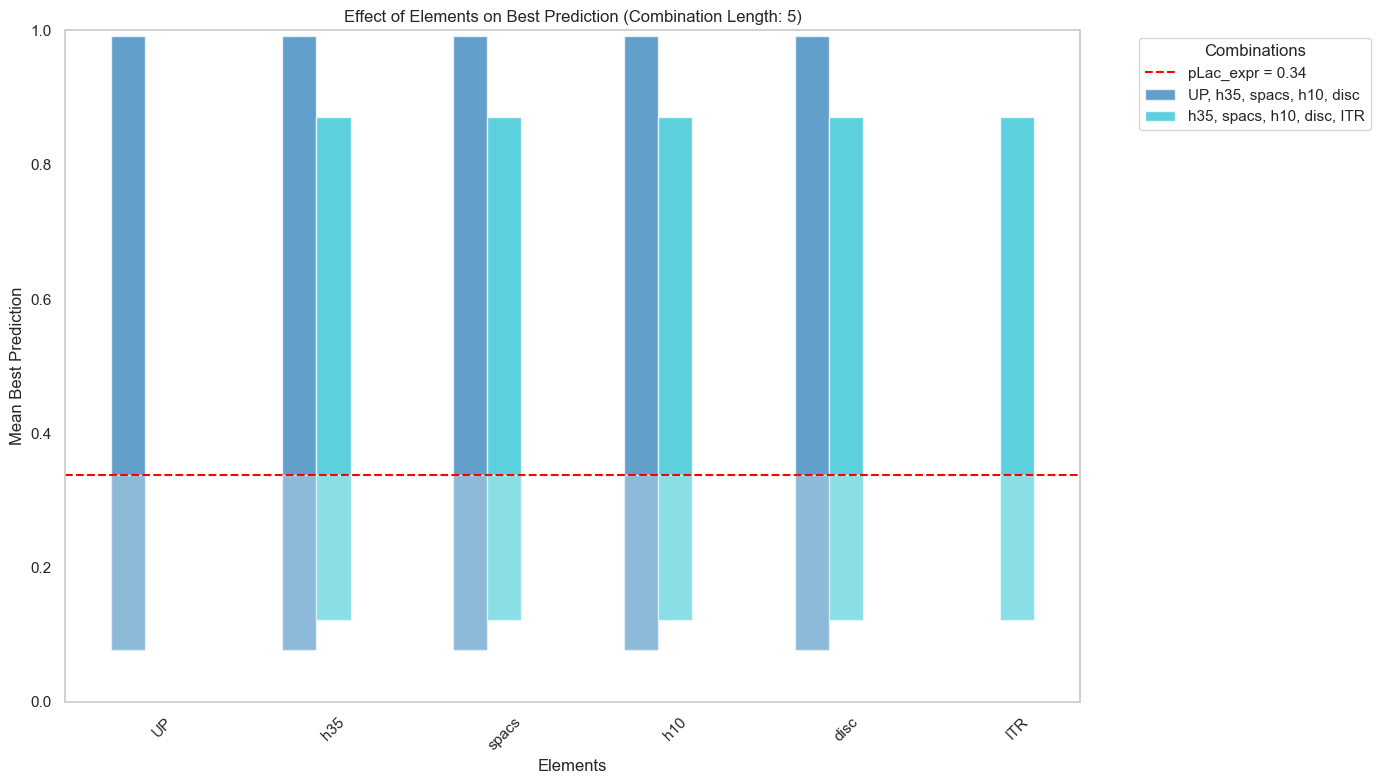

In [ ]:
# Prepare subsets for both target expressions
subsets = {
    "Target Expression 1": continuous_results_df[continuous_results_df['target_expression'] == 1],
    "Target Expression 0": continuous_results_df[continuous_results_df['target_expression'] == 0]
}

combination_lengths = continuous_results_df['combination_length'].unique()

# Loop through each combination length
for length in combination_lengths:
    if length == 1 or length == 6:  # Skip lengths 1 and 6 as per requirement
        continue

    elements = ['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']
    relevant_combinations = [
        combo for combo in itertools.combinations(elements, length)
    ]

    # Prepare data for plotting
    bar_data = {subset_name: {feature: [] for feature in elements} for subset_name in subsets.keys()}
    bar_labels = []
    colors = plt.cm.tab10(np.linspace(0, 1, len(relevant_combinations)))

    used_combinations = []

    for i, combination in enumerate(relevant_combinations):
        label = f"{', '.join(combination)}"
        has_data = False

        for subset_name, subset_df in subsets.items():
            subset = subset_df[subset_df['combination_length'] == length]
            for feature in elements:
                if feature in combination:
                    # Filter rows that match the current combination
                    subset_condition = subset[feature] & subset[[col for col in combination]].all(axis=1)
                    mean_prediction = subset[subset_condition]['best_prediction'].mean() if not subset_condition.empty else 0
                else:
                    mean_prediction = np.nan  # Set to NaN for absent features

                bar_data[subset_name][feature].append(mean_prediction)
                if not np.isnan(mean_prediction) and mean_prediction > 0:
                    has_data = True

        if has_data:
            bar_labels.append(label)
            used_combinations.append(i)

    # Filter colors and data based on used_combinations
    filtered_colors = [colors[i] for i in used_combinations]
    filtered_bar_data = {
        subset_name: {
            feature: [bar_data[subset_name][feature][i] for i in used_combinations]
            for feature in elements
        }
        for subset_name in subsets.keys()
    }

    # Plotting
    x = np.arange(len(elements))
    bar_width = 0.2
    offset = 0

    plt.figure(figsize=(14, 8))

    for subset_name, color_offset in zip(subsets.keys(), range(len(subsets))):
        for i, (label, color) in enumerate(zip(bar_labels, filtered_colors)):
            y = [
                filtered_bar_data[subset_name][feature][i] - pLac_expr
                if not np.isnan(filtered_bar_data[subset_name][feature][i]) else 0
                for feature in elements
            ]
            plt.bar(
                x + i * bar_width + offset * bar_width,
                y,
                bar_width,
                bottom=pLac_expr,
                label=label if subset_name == "Target Expression 1" else None,
                color=color,
                alpha=0.7 if subset_name == "Target Expression 1" else 0.5
            )

    # Add the horizontal line at pLac_expr
    plt.axhline(y=pLac_expr, color='red', linestyle='--', label=f'pLac_expr = {pLac_expr:.2f}')

    plt.xlabel('Elements')
    plt.ylabel('Mean Expression')
    plt.ylim(0, 1)
    plt.title(f'Effect of Elements on Expression (Combination Length: {length})')
    plt.xticks(x + bar_width * (len(bar_labels) / 2), elements, rotation=45)
    plt.legend(title="Combinations", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(False)

    # Show the plot
    plt.show()
